In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from tabulate import tabulate
from tkinter import Tk, filedialog, simpledialog, messagebox
import statsmodels.api as sm
import BiQ_Common_Fxns as BiQ
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

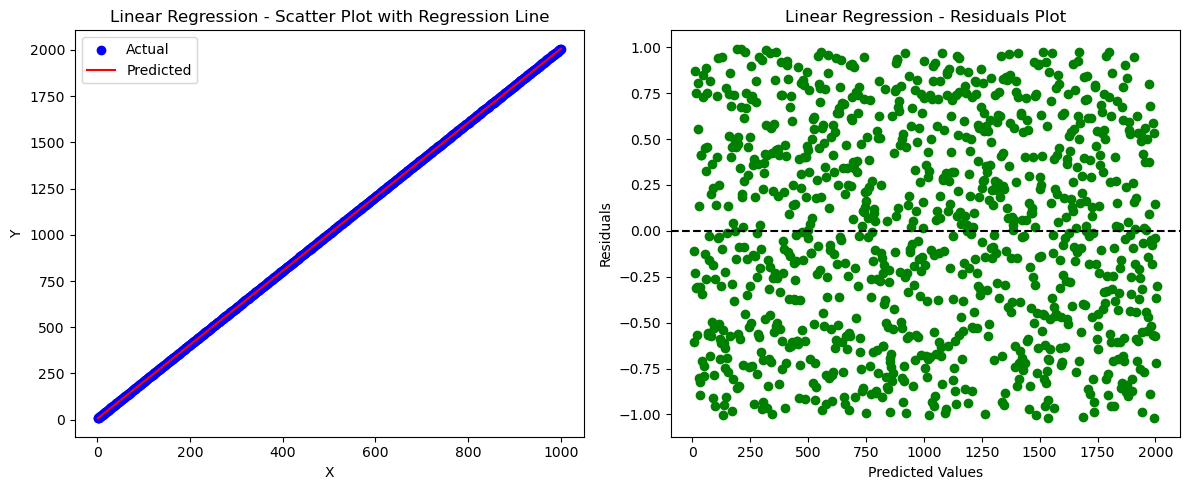

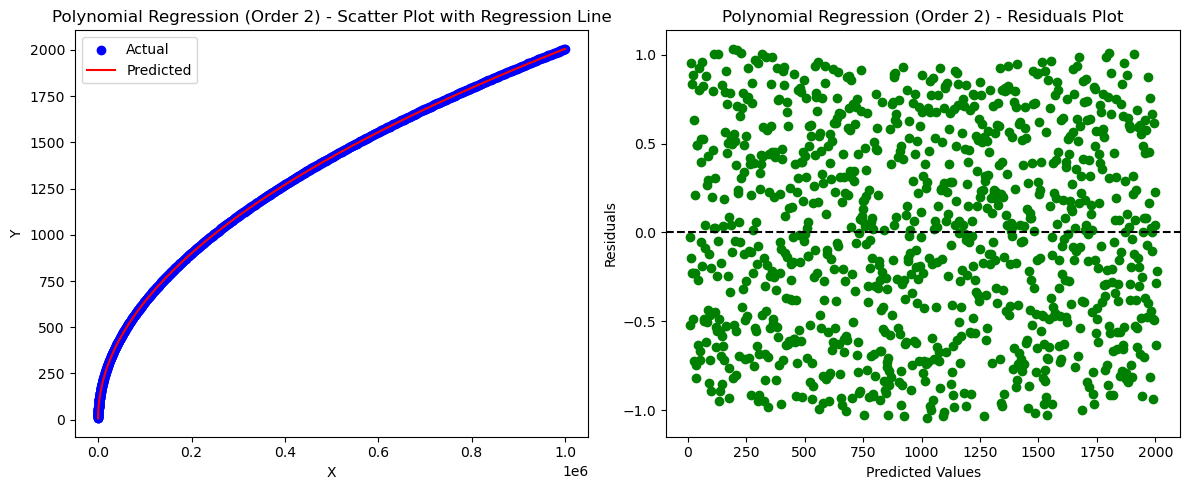

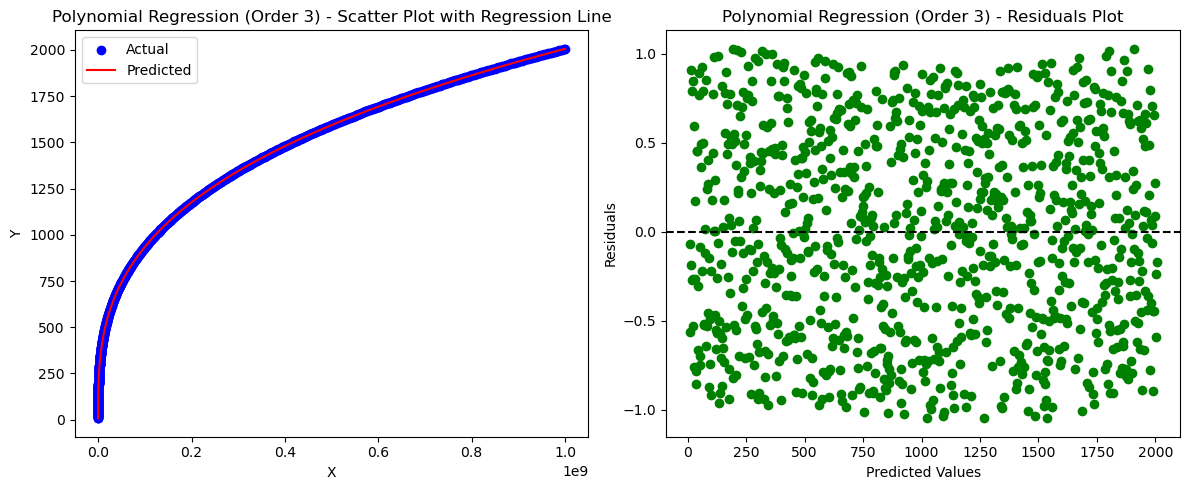


Linear Regression Coefficients:
+---------------+------------+--------------+-----------+---------+
| Coefficient   |   Estimate |   Std. Error |   t value |   P>|t| |
+===============+============+==============+===========+=========+
| const         |      6.003 |        0.036 |   164.492 |       0 |
+---------------+------------+--------------+-----------+---------+
| Ind           |      2     |        0     | 31663.8   |       0 |
+---------------+------------+--------------+-----------+---------+

Polynomial Regression (Order 2) Coefficients:
+---------------+------------+--------------+-----------+---------+
| Coefficient   |   Estimate |   Std. Error |   t value |   P>|t| |
+===============+============+==============+===========+=========+
| const         |      5.918 |        0.055 |   108.156 |   0     |
+---------------+------------+--------------+-----------+---------+
| x1            |      2.001 |        0     |  7923.66  |   0     |
+---------------+------------+------

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from tabulate import tabulate
from tkinter import Tk, filedialog, simpledialog, messagebox
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from tabulate import tabulate

def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    try:
        df = pd.read_excel(file_path)  # Read Excel file into a temporary DataFrame
        df = df.dropna(axis=1, how='all')  # Drop columns that are entirely blank
        return df  # Return the DataFrame
    except Exception as e:
        print(f"Error reading Excel file: {e}")  # Print error message if file reading fails
        return None  # Return None if an error occurs

def get_user_column_selection(df, title):
    """Gets user input for selecting a column using dialog boxes."""
    # Get column names from the DataFrame
    columns = df.columns.tolist()

    while True:
        col_name = input(f"Enter the column name for {title}:\nAvailable columns: {', '.join(columns)}\n")
        if col_name in columns:
            return col_name
        else:
            print(f"Column '{col_name}' not found in the DataFrame.")

def fit_linear_regression(df, x_col, y_col):
    """Fit a linear regression model."""
    X = df[[x_col]]
    y = df[y_col]
    model = LinearRegression()
    model.fit(X, y)
    return model

def fit_polynomial_regression(df, x_col, y_col, degree):
    """Fit a polynomial regression model."""
    X = df[[x_col]]
    y = df[y_col]

    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)
    return model, polynomial_features

def calculate_regression_stats(model, X, y):
    """Calculate regression statistics using statsmodels."""
    X = sm.add_constant(X)  # Add constant term for intercept
    model = sm.OLS(y, X).fit()  # Fit ordinary least squares (OLS) model
    return model

def plot_linear_regression(model, X, y, title):
    """Plot linear regression results."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    feature_col = X.columns[0]
    X_feature = X[feature_col].values.reshape(-1, 1)  # Convert feature column to a 2D array
    
    axes[0].scatter(X_feature[:, 0], y, color='blue', label='Actual')
    
    # Check and adjust the shape of X_feature for prediction
    if X_feature.shape[1] != model.params.shape[0] - 1:  # Subtract 1 for the intercept
        raise ValueError("Model and feature shape mismatch for prediction.")
    
    X_with_intercept = sm.add_constant(X_feature)  # Add constant for the intercept
    axes[0].plot(X_feature[:, 0], model.predict(X_with_intercept), color='red', label='Predicted')
    
    axes[0].set_title(f'{title} - Scatter Plot with Regression Line')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()

    # Residuals plot
    residuals = y - model.predict(X_with_intercept)
    axes[1].scatter(model.predict(X_with_intercept), residuals, color='green')
    axes[1].axhline(y=0, color='black', linestyle='--')
    axes[1].set_title(f'{title} - Residuals Plot')
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()


def plot_polynomial_regression(model, X, y, title):
    """Plot polynomial regression results."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    if isinstance(X, np.ndarray):
        num_features = X.shape[1]  # Get the number of features from X
        columns_names = [f'Feature_{i+1}' for i in range(num_features)]  # Create column names
        X = pd.DataFrame(X, columns=columns_names)
    
    # Adjust this line to use the correct column name
    feature_col = X.columns[-1]  # Assuming the last column is the one you want to use
    
    sort_indexes = X[feature_col].argsort()  # Use the correct column for sorting
    
    axes[0].scatter(X.iloc[sort_indexes][feature_col], y.iloc[sort_indexes], color='blue', label='Actual')
    axes[0].plot(X.iloc[sort_indexes][feature_col], model.predict(X.iloc[sort_indexes]), color='red', label='Predicted')
    
    axes[0].set_title(f'{title} - Scatter Plot with Regression Line')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()

    # Residuals plot
    residuals = y - model.predict(X)
    axes[1].scatter(model.predict(X), residuals, color='green')
    axes[1].axhline(y=0, color='black', linestyle='--')
    axes[1].set_title(f'{title} - Residuals Plot')
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()



def main():
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
    if not file_path:
        print("No file selected.")
        return

    # Read Excel file into DataFrame
    df = read_excel_file(file_path)
    if df is None:
        print("Error reading Excel file.")
        return

    x_col = get_user_column_selection(df, "Independent Variable (X)")
    if x_col is None:
        print("Error: Invalid input for independent variable.")
        return

    y_col = get_user_column_selection(df, "Dependent Variable (Y)")
    if y_col is None:
        print("Error: Invalid input for dependent variable.")
        return

    linear_model = fit_linear_regression(df, x_col, y_col)
    poly2_model, poly2_features = fit_polynomial_regression(df, x_col, y_col, degree=2)
    poly3_model, poly3_features = fit_polynomial_regression(df, x_col, y_col, degree=3)

    coef_data = []  # Initialize coef_data list
    models = {
        'Linear Regression': (linear_model, None),  # No features for linear regression
        'Polynomial Regression (Order 2)': (poly2_model, poly2_features),
        'Polynomial Regression (Order 3)': (poly3_model, poly3_features),
    }

    for model_name, (model, features) in models.items():
        coef_results = []  # Initialize coef_results for each model
        X = df[[x_col]] if features is None else features.transform(df[[x_col]])
        y = df[y_col]
        model = calculate_regression_stats(model, X, y)
        coef_names = model.params.index.tolist()  # Get coefficient names

        for coef_name, coef_value, std_err, t_value, p_value in zip(
            model.params.index, model.params.values, model.bse.values, model.tvalues.values,
            model.pvalues.values
        ):
            coef_results.append([coef_name, coef_value.round(3), std_err.round(3),
                                 t_value.round(3), p_value.round(3)])

        coef_data.append([model_name] + coef_results)

        # Plot regression results
        if 'Linear' in model_name:
            plot_linear_regression(model, X, y, model_name)
        elif 'Polynomial' in model_name:
            plot_polynomial_regression(model, X, y, model_name)

    # Print Coefficients Table
    for model_coef_data in coef_data:
        print(f"\n{model_coef_data[0]} Coefficients:")
        print(tabulate(model_coef_data[1:], headers=["Coefficient", "Estimate", "Std. Error",
                                                     "t value", "P>|t|"],
                       tablefmt="grid"))

if __name__ == "__main__":
    main()
